# Identifying parameters when branch lengths are not known

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from data import *
from phylo import *
from scipy.optimize import minimize
from random import seed
%matplotlib inline

In [2]:
random_seed = 1
np.random.seed(random_seed)
seed(random_seed)

pi = np.array([.1, .2, .3, .4])
sequence_length = 500
extant_taxa = 100

initial_sequence = random_sequence(sequence_length, pi)
tree = phylogenetic_tree(extant_taxa)
Q = f81(pi)
data = generate_data(initial_sequence, Q, tree)

## Infer with branch lengths known

In [3]:
def negative_likelihood(pi):
    Q = f81(pi)
    return -prune(data, tree, Q, pi)

pi0 = np.array([.25, .25, .25, .25])
sumtoone = lambda x: np.sum(x[-4:])-1
constraints = {'type':'eq', 'fun':sumtoone}
bounds = 4*((0,2),)
result = minimize(negative_likelihood, pi0, bounds=bounds, constraints=constraints)
approx = result.x

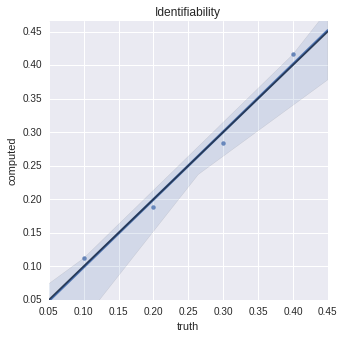

In [4]:
known_results = pd.DataFrame({'truth':pi, 'computed': approx})
plt.figure(figsize=(5, 5))
sns.regplot(x='truth', y='computed', data=known_results)
both = np.hstack([approx, pi])
xmin = .05
xmax = .45
ymin = np.min(both)-.05
ymax = np.max(both)+.05
x = np.linspace(xmin, xmax, 2)
plt.plot(x, x, color='black', alpha=.5)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.title('Identifiability')
plt.show()

## Infer with branch lengths unknown

In [5]:
def negative_likelihood_bl(x):
    pi = x[:4]
    t = x[4:]
    Q = f81(pi)
    extant_taxa = data.shape[0]
    sequence_length = data.shape[1]
    u = Q.shape[0]
    L = np.zeros((u, sequence_length, 2*extant_taxa-1))
    all_sequence_indices = np.arange(sequence_length)
    for node in tree.traverse('postorder'):
        index = int(node.name)
        sequence = data[index, :]
        if node.is_leaf():
            L[sequence, all_sequence_indices, index] = 1
        else:
            left_child, right_child = node.children
            left_index = int(left_child.name)
            right_index = int(right_child.name)
            L_left = L[:, :, left_index]
            L_right = L[:, :, right_index]
            t_left = t[left_index]
            t_right = t[right_index]
            try:
                P_left = expm(t_left*Q)
                P_right = expm(t_right*Q)
            except ValueError:
                raise Exception('Could not compute matrix exponentials!')
            L[:, :, index] = np.dot(P_left, L_left) * np.dot(P_right, L_right)
    u = Q.shape[0]
    l0 = np.dot(pi.reshape(1, u), L[:, :, 0])
    return -np.sum(np.log(l0))

Make a uniform guess for branch lengths.

In [ ]:
n_branches = 2*extant_taxa-2
t0 = np.ones(n_branches)*(.01+.5)/2
x0_bl = np.hstack([pi0, t0])
sumtoone = lambda x: np.sum(x[:4])-1
constraints = {'type':'eq', 'fun':sumtoone}
bounds = (4+n_branches)*((0,2),)
result_bl = minimize(negative_likelihood_bl, x0_bl, bounds=bounds, constraints=constraints)
approx_bl = result_bl.x

In [6]:
t = np.zeros(n_branches)
for node in tree.traverse('preorder'):
    if not node.is_root():
        index = int(node.name)
        t[index] = node.dist

In [7]:
params_df = pd.DataFrame({'truth':pi, 'computed':approx_bl[:4]})
bls_df = pd.DataFrame({'truth':t, 'computed':approx_bl[4:]})

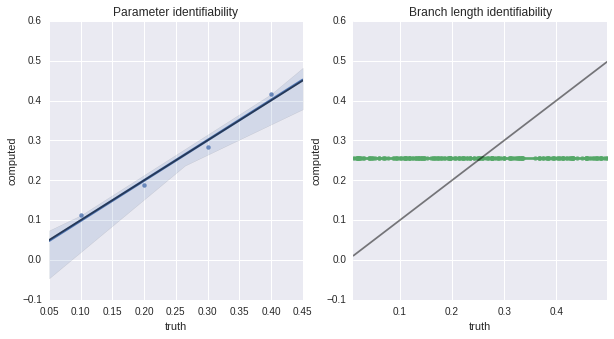

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.regplot(x='truth', y='computed', data=params_df, ax=axs[0])
xmin = .05
xmax = .45
x = np.linspace(xmin, xmax, 2)
axs[0].plot(x, x, color='black', alpha=.5)
axs[0].set_xlim([xmin, xmax])
axs[0].set_title('Parameter identifiability')

sns.regplot(x='truth', y='computed', data=bls_df, ax=axs[1])
xmin = np.min(t)
xmax = np.max(t)
x = np.linspace(xmin, xmax, 2)
axs[1].plot(x, x, color='black', alpha=.5)
axs[1].set_xlim([xmin, xmax])
axs[1].set_title('Branch length identifiability')

plt.show()

So we still get parameters, even though we don't get branch lengths... anyone know what to make of this?